In [1]:
# look how to speed up training (smart device choosing)
import multiprocessing
import os
import torch
f'cpu: {multiprocessing.cpu_count()}, memory: {(os.sysconf("SC_PAGE_SIZE") * os.sysconf("SC_PHYS_PAGES"))/(1024.**3)}, gpu: {torch.cuda.get_device_name(0)}'

'cpu: 2, memory: 12.686656951904297, gpu: Tesla P100-PCIE-16GB'

In [2]:
import torch.functional as F
from torch import nn
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        self.noisy_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.noisy_bias = torch.nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()
        
    def reset_parameters(self):
        # normal weights
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

        # normal bias
        fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        torch.nn.init.uniform_(self.bias, -bound, bound)

        torch.nn.init.kaiming_uniform_(self.noisy_weight, a=math.sqrt(5))

        # NOTE: the following is unfactorized, which is slower, which is bad for DQN
        # noise weights (3.2 INITIALISATION OF NOISY NETWORKS)
        noise_weight_bound = math.sqrt(3 / self.in_features) 
        torch.nn.init.uniform_(self.noisy_weight, -noise_weight_bound, bound)

        # noise bias
        torch.nn.init.constant_(self.noisy_bias, 0.017)
        
    def forward(self, input):
        weight_noise = torch.randn((self.in_features, self.out_features))
        bias_noise = torch.randn((self.out_features))
        return F.linear(input, self.weight + self.noisy_weight * weight_noise, self.bias + self.noisy_bias * bias_noise)

In [1]:
  !apt-get install -y xvfb python-opengl > /dev/null 2>&1
  !pip install gym pyvirtualdisplay > /dev/null 2>&1
  !apt-get install x11-utils > /dev/null 2>&1
  !pip uninstall -y pyglet
  !pip install pyglet==v1.5.0

Found existing installation: pyglet 1.5.0
Uninstalling pyglet-1.5.0:
  Successfully uninstalled pyglet-1.5.0
  Using cached pyglet-1.5.0-py2.py3-none-any.whl (1.0 MB)


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab Workspace/DQN

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Workspace


In [11]:
%cd /content/gdrive/My Drive/Colab Workspace/dqn
!git status

/content/gdrive/My Drive/Colab Workspace/dqn
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   DQN.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	test.py

no changes added to commit (use "git add" and/or "git commit -a")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Workspace


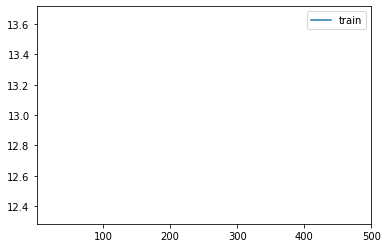

AttributeError: ignored

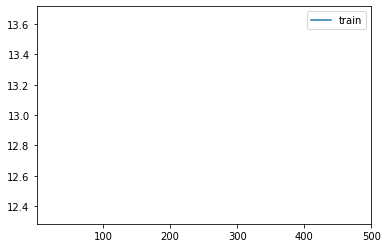

In [5]:
if display is None:
  from IPython import display as ipythondisplay
  from pyvirtualdisplay import Display
  display = Display(visible=0, size=(400, 300))
  display.start()

import gym
from collections import deque
import torch
from tqdm import tqdm
import random
import copy
import numpy as np
import math
from torch import nn
import torch.nn.functional as F
import copy
from gym.wrappers import Monitor
from fastprogress.fastprogress import master_bar

env = Monitor(gym.make('CartPole-v1'), './monitor/', force=True, video_callable=False)

h = {
    # Model architecture
    'input_layer_size': env.observation_space.shape[0],
    'output_layer_size': env.action_space.n,
    # DQN
    'replay_memory_size': 8192,
    'start_random_action_probability': 1.0,
    'end_random_action_probability': 0.05,
    'random_action_probability_decay': 5000,
    'future_reward_weighting': 0.99,
    'ddqn_loss': True,
    'noisy_net': False,
    # Training
    'minibatch_size': 128,
    'n_episodes_update_target_function': 100,
    'n_training_episodes': 500,
    'learning_rate': 1e-4,
    'clamp_gradients': True,
    'clamp_min': -1,
    'clamp_max': 1,
}

action_value_function = torch.nn.Sequential(
    NoisyLinear(h['input_layer_size'], 16) if h['noisy_net'] else torch.nn.Linear(h['input_layer_size'], 16),
    torch.nn.ReLU(),
    NoisyLinear(16, 32) if h['noisy_net'] else torch.nn.Linear(16, 32),
    torch.nn.ReLU(),
    NoisyLinear(32, 32) if h['noisy_net'] else torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    NoisyLinear(32, h['output_layer_size']) if h['noisy_net'] else torch.nn.Linear(32, h['output_layer_size']),
)
target_action_value_function = copy.deepcopy(action_value_function)
target_action_value_function.eval()


replay_memory = deque([], h['replay_memory_size'])

optimizer = torch.optim.Adam(action_value_function.parameters(), lr=h['learning_rate'])

def choose_action():
    # bug fix #3:this new epsilon formula improved the model by 50%
    random_action_probability = h['end_random_action_probability'] + (h['start_random_action_probability'] - h['end_random_action_probability']) * math.exp(-1. * env.get_total_steps() / h['random_action_probability_decay'])
    # >= son of fuck bug fix #4
    exploit = random.uniform(0, 1) >= random_action_probability
    if h['noisy_net'] or exploit:
      action_value_function.eval()
      with torch.no_grad():
        q_value_max = action_value_function(torch.Tensor(obs)).max(dim=0)
      action_value_function.train()

      return q_value_max[1].item()
    else:
      return env.action_space.sample()

def update_model():
      minibatch = random.sample(replay_memory, h['minibatch_size'])
      minibatch = {key: np.stack([b[key] for b in minibatch]) for key in minibatch[0].keys()}

      q_value = action_value_function(torch.Tensor(minibatch['obs'])).gather(1, torch.Tensor(minibatch['action']).long().unsqueeze(1)).squeeze(1)
      target_next_q_values = target_action_value_function(torch.Tensor(minibatch['next_obs']))
      dones = torch.Tensor(minibatch['done'])
      future_reward_weighting = torch.Tensor([h['future_reward_weighting']])

      if h['ddqn_loss']:
        next_q_values = action_value_function(torch.Tensor(minibatch['next_obs']))
        next_q_value = target_next_q_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
      else:
        next_q_value = target_next_q_values.max(dim=1)[0]

      target_q_value = torch.Tensor(minibatch['reward']) + future_reward_weighting * next_q_value * (1 - dones)

      loss = torch.nn.functional.smooth_l1_loss(q_value, target_q_value)
      optimizer.zero_grad()
      loss.backward()
      if h['clamp_gradients']:
        for param in action_value_function.parameters():
          param.grad.data.clamp_(h['clamp_min'], h['clamp_max'])
      optimizer.step()

      return loss.item()

def plot_reward_update(epoch, epochs, mb, reward):
    """ dynamically print the reward plot during the training loop.
        expects epoch to start from 1.
    """
    x = range(1, epoch+1)
    graphs = [[x,reward]]
    x_margin = 0.2
    y_margin = 0.05
    x_bounds = [1-x_margin, epochs+x_margin]
    y_bounds = [np.min(reward)-y_margin, np.max(reward)+y_margin]

    mb.update_graph(graphs, x_bounds)

mb = master_bar(range(1, h['n_training_episodes']+1))
for episode in mb:
  obs = env.reset()

  # bug fix #3: was updating model params in STEPS, not EPISODE! multiple updates per episode
  if episode % h['n_episodes_update_target_function'] == 0:
    target_action_value_function = copy.deepcopy(action_value_function)
    target_action_value_function.eval()
      
  for step in range(1000):
    action = choose_action()

    next_obs, reward, done, info = env.step(action)
    replay_memory.append({'obs': obs, 'action': action, 'reward': reward, 'next_obs': next_obs, 'done': done})
    obs = next_obs

    if len(replay_memory) >= h['minibatch_size']:
      update_model()

    if done:
      plot_reward_update(episode, h['n_training_episodes'], mb, env.get_episode_rewards())
      break
env.close()

In [3]:
display

<function IPython.core.display.display>